In [1]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA
import matplotlib.pyplot as plt
import itertools
from dataclasses import dataclass, field
from typing import List

In [2]:
import warnings
warnings.filterwarnings('ignore')

### Задание 1
Прочитайте базу my_PJME_MW.csv и сделайте ее перрасчет (ресемплинг) в представление по 1 месяцу.

In [51]:
energy_df = pd.read_csv('my_PJME_MW.csv', index_col=[0], parse_dates=[0], usecols=[0, 1, 2])

In [52]:
energy_df = energy_df.resample('M').mean()
energy_df.head()

,PJME_MW
Date,
2002-01-31,31075.399731
2002-02-28,30239.166667
2002-03-31,28875.256720
2002-04-30,28534.731572
2002-05-31,28073.653226


### Задание 2
Подберите параметры модели SARIMAX для этого ряда.

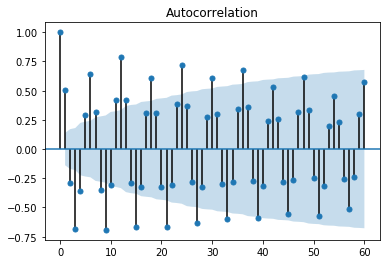

In [53]:
sm.graphics.tsa.plot_acf(energy_df['PJME_MW'].values, lags=60)
plt.show()

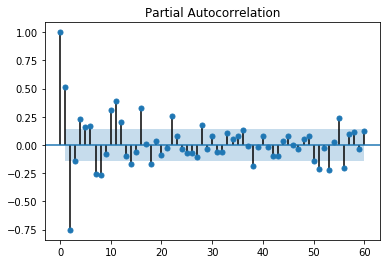

In [54]:
sm.graphics.tsa.plot_pacf(energy_df['PJME_MW'].values, lags=60)
plt.show()

In [56]:
@dataclass
class BestParams:
    best_pdq: list = field(default_factory=list)
    best_seas_pdq: list = field(default_factory=list)
    score: int = 15000

p = d = q = range(0, 3)
pdq = list(itertools.product(p, d, q))
p = [0, 1]
d = [0, 1]
q = range(0, 3)
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

best = BestParams()

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(energy_df['PJME_MW'].values[:-12],
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            #print(f'SARIMAX{param}x{param_seasonal} - AIC:{results.aic}')
            if results.aic < best.score:
                best = BestParams(param, param_seasonal, results.aic)
        except Exception as e:
            print(e)
            continue
print(best)


BestParams(best_pdq=(0, 1, 2), best_seas_pdq=(1, 1, 2, 12), score=2606.3201810986884)


In [57]:
mod = sm.tsa.statespace.SARIMAX(energy_df['PJME_MW'].values[:-12],
                                            order=best.best_pdq,
                                            seasonal_order=best.best_seas_pdq,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
results = mod.fit()

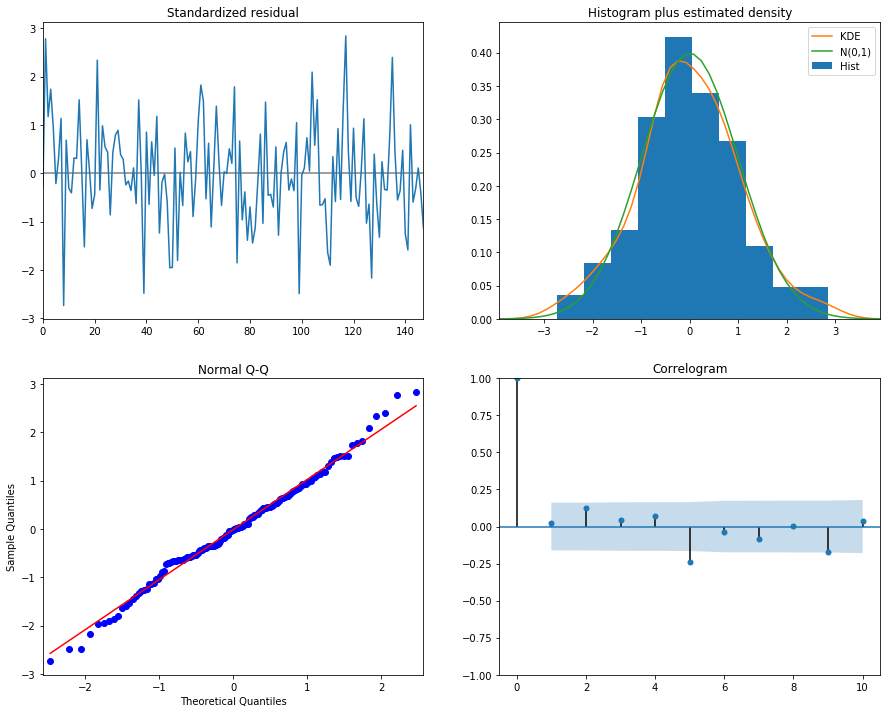

In [58]:
results.plot_diagnostics(figsize=(15,12))
plt.show()

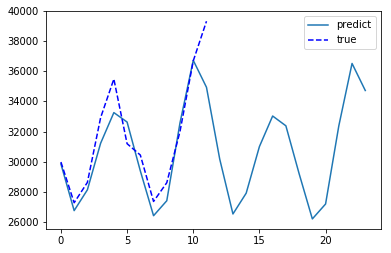

In [59]:
pred_dynamic = results.forecast(24)    #делаем предсказание на 3 точки от текущего конца ряда

plt.plot(pred_dynamic, label='predict' )
#Отобразим истинный значения
plt.plot(energy_df['PJME_MW'].values[-12:],'--b',label='true')
plt.legend()

plt.show()

### Задание 3
Сделайте вывод о том, как изменилась модель по сравнению с недельной.

На месячных измерениях предсказания значительно точнее по сравнению с недельными.

### Задание 4
Постройте ACF, PACF и модель ARIMA для СOVID_19

In [60]:
covid = pd.read_csv('covid_19_data.csv')
covid_russia = covid.loc[covid['Country/Region']=='Russia', :]
covid_russia = covid_russia.iloc[:, [1, 5]]
covid_russia['ObservationDate'] = pd.to_datetime(covid_russia['ObservationDate'])
covid_russia = covid_russia.set_index(covid_russia['ObservationDate'])
covid_russia = covid_russia.drop('ObservationDate', axis=1)
covid_russia = covid_russia.sort_index()
covid_russia.head()

,Confirmed
ObservationDate,
2020-01-31,2.0
2020-02-01,2.0
2020-02-02,2.0
2020-02-03,2.0
2020-02-04,2.0


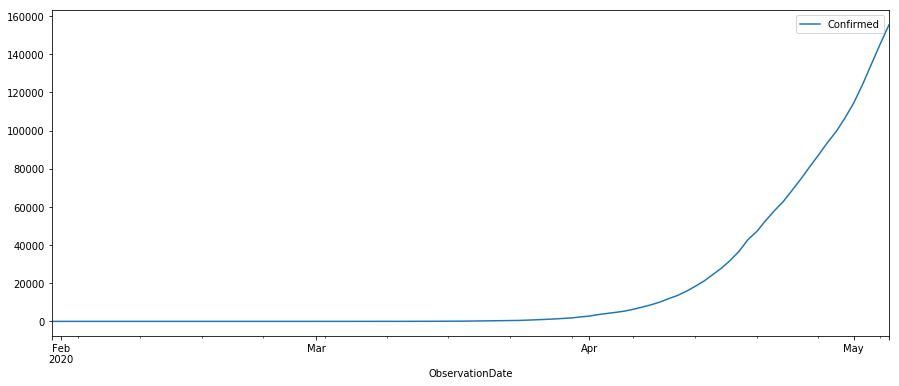

In [33]:
covid_russia.plot(figsize=(15, 6))

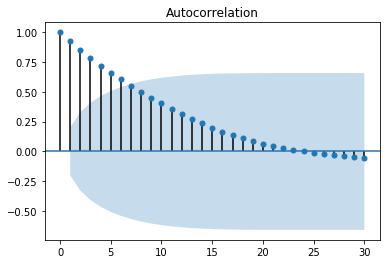

In [34]:
sm.graphics.tsa.plot_acf(covid_russia['Confirmed'].values, lags=30)
plt.show()


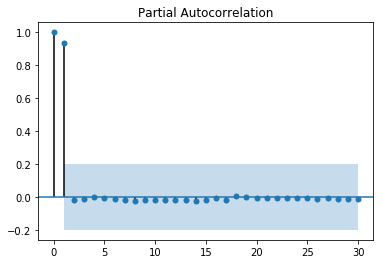

In [35]:
sm.graphics.tsa.plot_pacf(covid_russia['Confirmed'].values, lags=30)
plt.show()

AIC = 1228.9828106482923


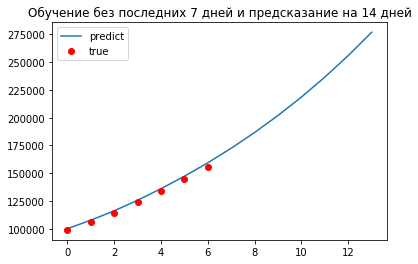

In [67]:
mod = sm.tsa.statespace.SARIMAX(covid_russia['Confirmed'].values[:-7],
                                            order=[1, 0, 5],
                                            seasonal_order=[0,0,0, 0],
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
results = mod.fit()
print(f'AIC = {results.aic}')

pred_dynamic = results.forecast(14)

plt.plot(pred_dynamic, label='predict' )
#Отобразим истинный значения
plt.plot(covid_russia['Confirmed'].values[-7:],'or',label='true')
plt.title('Обучение без последних 7 дней и предсказание на 14 дней')
plt.legend()

plt.show()

AIC = 1064.297728251363


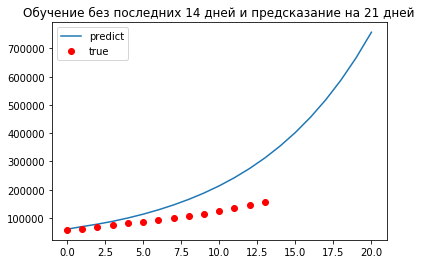

In [68]:
mod = sm.tsa.statespace.SARIMAX(covid_russia['Confirmed'].values[:-14],
                                            order=[1, 0, 5],
                                            seasonal_order=[0,0,0, 0],
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
results = mod.fit()
print(f'AIC = {results.aic}')

pred_dynamic = results.forecast(21)

plt.plot(pred_dynamic, label='predict' )
#Отобразим истинный значения
plt.plot(covid_russia['Confirmed'].values[-14:],'or',label='true')
plt.title('Обучение без последних 14 дней и предсказание на 21 дней')
plt.legend()

plt.show()

### Задание 5
В последние 2 недели в РФ удалось сдержать геометрический рост количества заболеваемых.
Если строить модель по данным без последних 14 дней, то она сильно расходится с реальным рядом в большую сторону.
На модели без последних 7 дней строятся очень точные предсказания (модель учла новый тренд)
